In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using KernelDensity
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP

In [2]:
include("../model-38/likelihood.jl")
include("../model-38/utill_model.jl")
include("../utill.jl")

plot_projections (generic function with 1 method)

In [3]:
function hist_2d(smpls, dim_1, dim_2; nbins=40, axmin = true, axmax=true)
    smpl_tmp, smpl_w = flatview(unshaped.(smpls.v)), smpls.weight
    if axmin == true
        hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), nbins=nbins)
    else
       hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), (range(axmin[1], stop=axmax[1], length=nbins), range(axmin[2], stop=axmax[2], length=nbins))) 
    end
    hist_tmp = normalize(hist_tmp, mode=:pdf) 
    return hist_tmp
end

hist_2d (generic function with 1 method)

In [4]:
β1 = 0.015
β2 = 0.008
β3 = 0.006 
    

prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.07, 0.25), truncated(Normal(0.2, 0.04), 0.07, 0.25)],
        ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 3.5), truncated(Normal(4.0, 2.0), 1.0, 3.5)],
        mixt_pow =  0.52 .. 1.0 ,
        waist = [truncated(Normal(2.9, 0.03), 2.65, 3.3)],
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        resy = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
        psx = [truncated(Normal(27.1, 27.1*β1), 0., Inf), truncated(Normal(21.6, 21.6*β1), 0., Inf), truncated(Normal(114.0, 114.0*β2), 0., Inf)], # pixels are in microns
        psy = [truncated(Normal(30.5, 30.5*β1), 0., Inf), truncated(Normal(23.4, 23.4*β1), 0., Inf), truncated(Normal(125.0, 125.0*β2), 0., Inf)],
        cam4_psx = truncated(Normal(121.8, 3*121.8*β3), 0., Inf), # original Pixel size (smaller) 91.0; Updated Pixel size (larger) 121.2
        cam4_psy = truncated(Normal(120.0, 3*120.0*β3), 0., Inf), # original Pixel size (smaller) 89.4; Updated Pixel size (larger) 120.6
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    );   

labels = [L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", L"\sigma'_x", L"\sigma'_y", L"\alpha", L"s", 
    L"\mu_x", L"\mu_x", L"\mu_x", L"\mu_x", L"\mu_y", L"\mu_y", L"\mu_y", L"\mu_y", 
    "ped", "lf", "a", 
    "res x", "res x", "res x", "res y", "res y", "res y", "res x", "res y", 
    "ps x", "ps x", "ps x", "ps y", "ps y", "ps y", "ps x", "ps y", 
    "la", "la", "la"
    ];

In [5]:
FPATH = "../../data/sampling_results/Benchmark-3/"

"../../data/sampling_results/Benchmark-3/"

In [340]:
readdir(FPATH)

20-element Array{String,1}:
 ".ipynb_checkpoints"
 "hc-1.hdf5"
 "hc-113.hdf5"
 "hc-188.hdf5"
 "hc-2.hdf5"
 "hc-26.hdf5"
 "hc-281.hdf5"
 "hc-3.hdf5"
 "hc-311.hdf5"
 "hc-322.hdf5"
 "lc-1.hdf5"
 "lc-137.hdf5"
 "lc-151.hdf5"
 "lc-169.hdf5"
 "lc-2.hdf5"
 "lc-225.hdf5"
 "lc-262.hdf5"
 "lc-299.hdf5"
 "lc-3.hdf5"
 "lc-343.hdf5"

In [290]:
filename = readdir(FPATH)[16]
smpl_tmp = bat_read(FPATH*filename)
samples = varshape(prior).(smpl_tmp);

# lc-225.hdf5" is possybly wrong 

In [291]:
filename

"lc-299.hdf5"

In [292]:
smpl_vect = mode(samples)

ShapedAsNT((tr_size = [0.08865092984737274, 0.08685055916836985], ang_spr = [5.41742475740272, 6.6972137848047355], ang_spr_2 = [2.0852482196246007, 2.813920092344551], mixt_pow = 0.5276317298475243, waist = [2.8326055455558206], algmx = [34.687803536503424, 35.32988921173699, 20.285737045181875, 34.698166461216914], algmy = [37.72395231453884, 39.31556155377764, 22.125810951718282, 35.33707329562723], cam4_ped = 16.52652952263535, cam4_light_fluct = 1.6873917108716128, cam4_light_amp = 2.906164382130757, resx = [0.6193289805851315, 2.644512467837638, 0.8447680631598413], resy = [0.38291420367876616, 2.388272950434264, 0.9287368187799329], cam4_resx = 3.6609319852387388, cam4_resy = 2.72294095013141, psx = [26.458073379334568, 21.69098332815158, 116.34164242227538], psy = [27.855487653158658, 24.94717672658912, 127.95121393722931], cam4_psx = 100.88548479042899, cam4_psy = 109.77913170727956, light_amp = [2.9294237140741584, 3.812606866842758, 2.554958995750579], s_cam = [0.0, 1.478, 1

In [293]:
# hist_tmp = hist_2d(samples, 1,2, nbins=40,)

# valss = sort([hist_tmp.weights...])
# valss_rc = valss ./ sum(valss)
# intt = [0.0001, 0.001, 0.006, 0.9999, 1]
# cvals = unique([valss[argmin(abs.(valss_rc .- i))] for i in intt])

# fig, ax= plt.subplots(1,1, figsize=(6,6))

# ax.contourf(
#     midpoints(hist_tmp.edges[1]), 
#     midpoints(hist_tmp.edges[2]), 
#     hist_tmp.weights', 
#     levels= 4, #cvals, 
#     cmap="Blues", alpha=0.6, antialiased=true) 

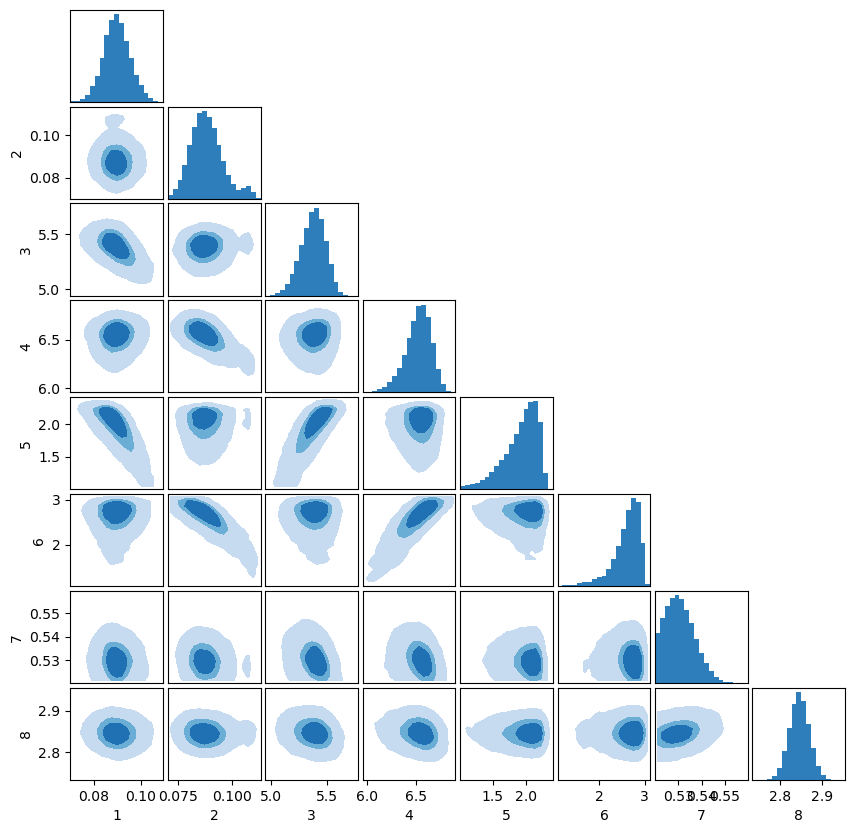

In [294]:
dims = [1,2,3,4,5,6,7,8]
names = [1,2,3,4,5,6,7,8]
levels = [0.0001, 0.65, 0.9, 0.95,  1,]
# levels = [0.001, 0.65, 0.95, 1,]
figsize = (10,10)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

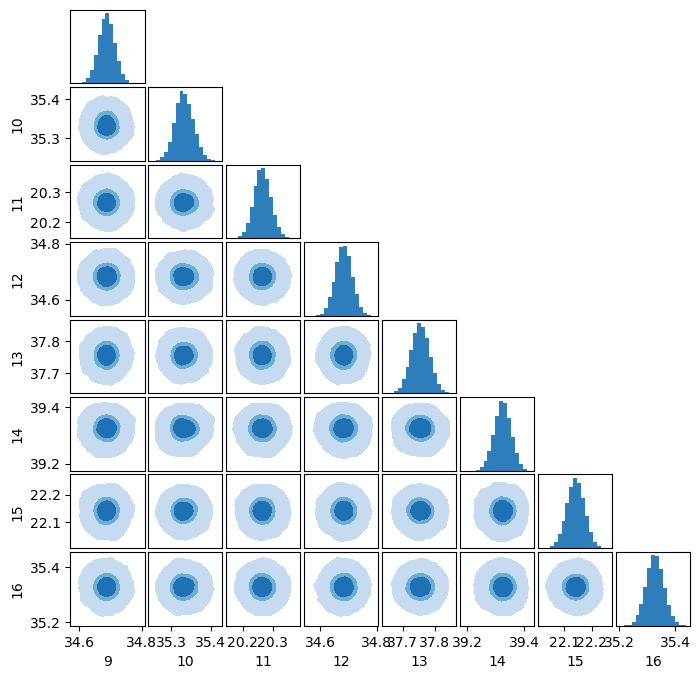

In [295]:
dims = [9,10,11,12,13,14, 15, 16]
names = [9,10,11,12,13,14, 15, 16]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

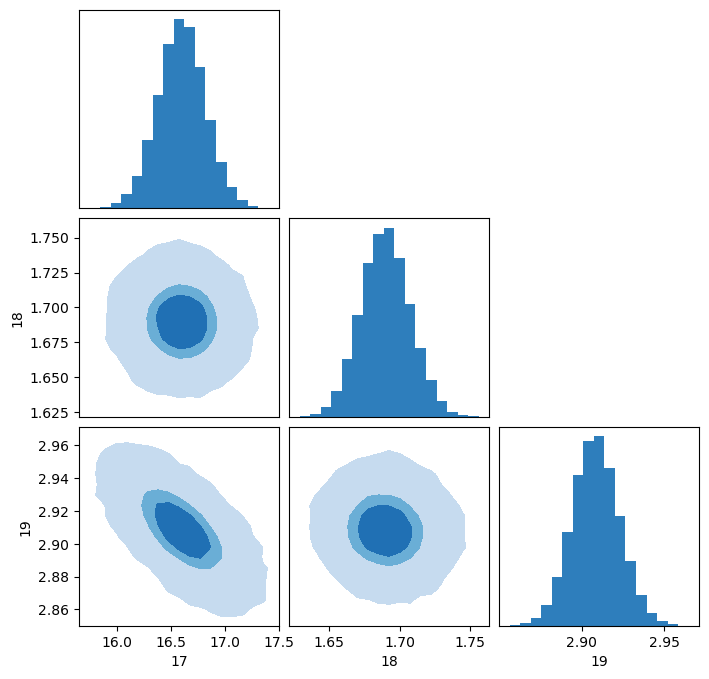

In [296]:
dims = [17,18,19]
names = [17,18,19]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

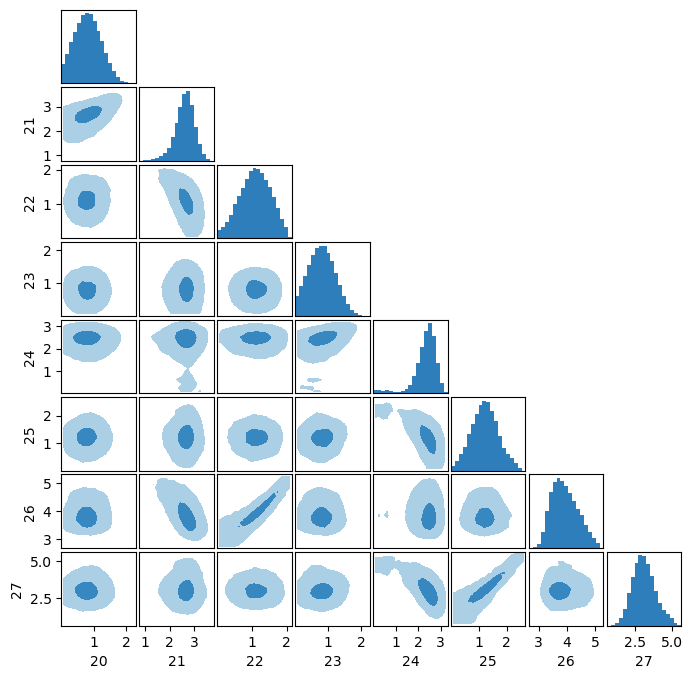

In [297]:
dims = [20,21,22,23,24,25,26,27]
names = [20,21,22,23,24,25,26,27]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

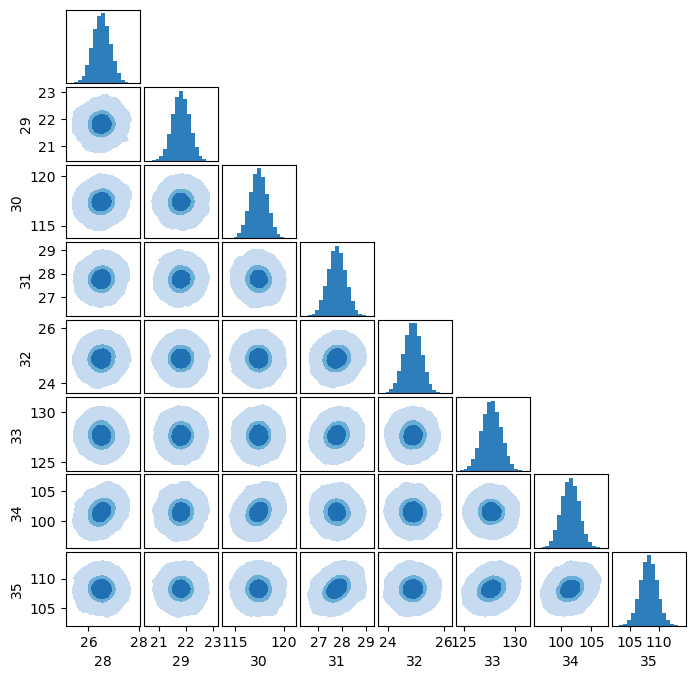

In [298]:
dims = [28,29,30,31,32,33,34,35]
names = [28,29,30,31,32,33,34,35]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

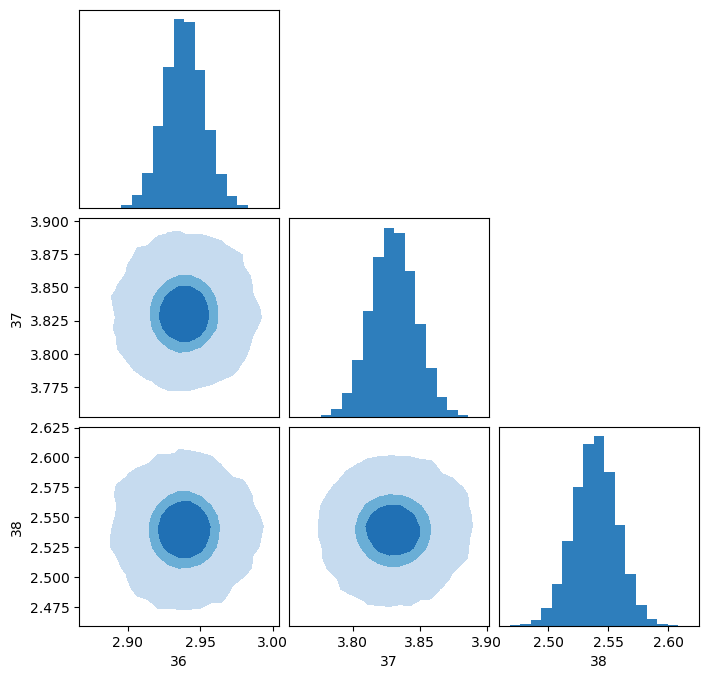

In [299]:
dims = [36,37,38]
names = [36,37,38]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

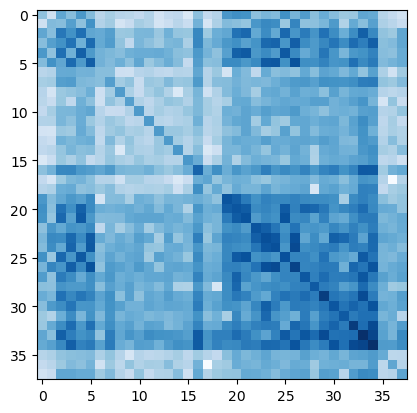

PyObject <matplotlib.image.AxesImage object at 0x7f989b1db0a0>

In [300]:
plt.imshow(log.(abs.(cov(flatview(unshaped.(samples.v))'))), cmap="Blues")

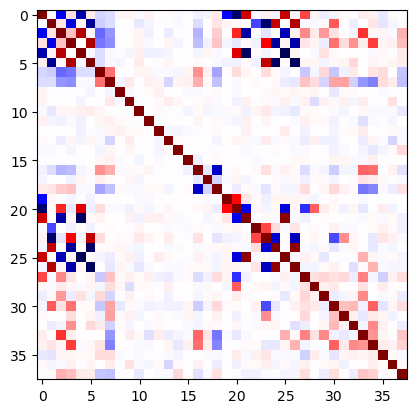

PyObject <matplotlib.image.AxesImage object at 0x7f989b4254c0>

In [335]:
dt_reg = flatview(unshaped.(samples.v)) ./ std(flatview(unshaped.(samples.v)), dims=2)
dt_reg = dt_reg .- mean(dt_reg, dims=2)
dt_reg = cov(dt_reg')
max = maximum(abs.(dt_reg))

plt.imshow(dt_reg, cmap="seismic", vmin=-max, vmax=max)

In [301]:
if filename[1:2] == "hc"
    
    conv_mat = load("../../data/experiment/dataset_2/m2/conv-matrix-upd-2.jld2") 

    global conv_matrices = (
        cam_1 = conv_mat["cam_1"],
        cam_2 = conv_mat["cam_2"],
        cam_3 = conv_mat["cam_3"],
        cam_4 = conv_mat["cam_4"], 
    ) 

    images = load("../../data/experiment/dataset_2/m2/images-satur.jld2")
    event_number = parse(Int64, filename[4:end-5])

    global event = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    );

end

In [302]:
if filename[1:2] == "lc"
    @show "true"
    conv_mat = load("../../data/experiment/dataset_2/m1/conv-matrix-upd-2.jld2") 

    global conv_matrices = (
        cam_1 = conv_mat["cam_1"],
        cam_2 = conv_mat["cam_2"],
        cam_3 = conv_mat["cam_3"],
        cam_4 = conv_mat["cam_4"], 
    ) 

    images = load("../../data/experiment/dataset_2/m1/images-satur.jld2")
    event_number = parse(Int64, filename[4:end-5])

    global event = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    );

end

"true" = "true"


(cam_1 = [0.0 210.0 … 0.0 25.0; 0.0 1.0 … 1.0 0.0; … ; 114.0 6.0 … 2.0 0.0; 247.0 13.0 … 1.0 10.0], cam_2 = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 9.0 0.0; 0.0 0.0 … 95.0 736.0], cam_3 = [172.0 180.0 … 85.0 183.0; 6.0 17.0 … 152.0 14.0; … ; 191.0 157.0 … 5.0 97.0; 260.0 37.0 … 180.0 204.0], cam_4 = [12.0 11.0 … 20.0 12.0; 17.0 14.0 … 18.0 18.0; … ; 15.0 17.0 … 19.0 16.0; 13.0 13.0 … 18.0 16.0], population = 8.990799903869629)

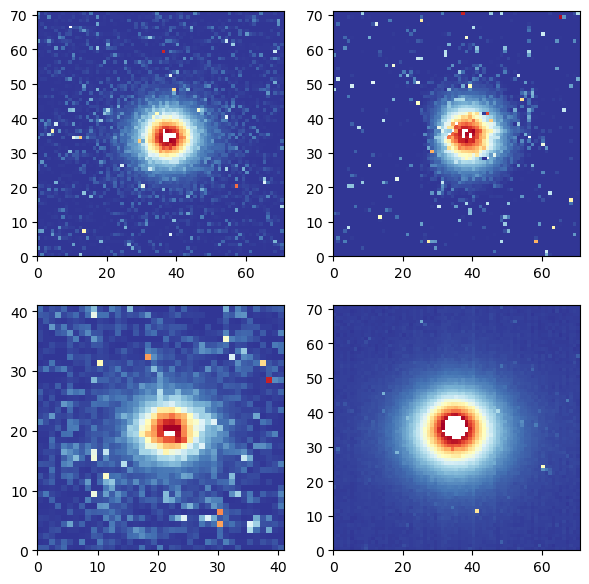

PyObject <matplotlib.collections.QuadMesh object at 0x7f989989a040>

In [303]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, cmap="RdYlBu_r")

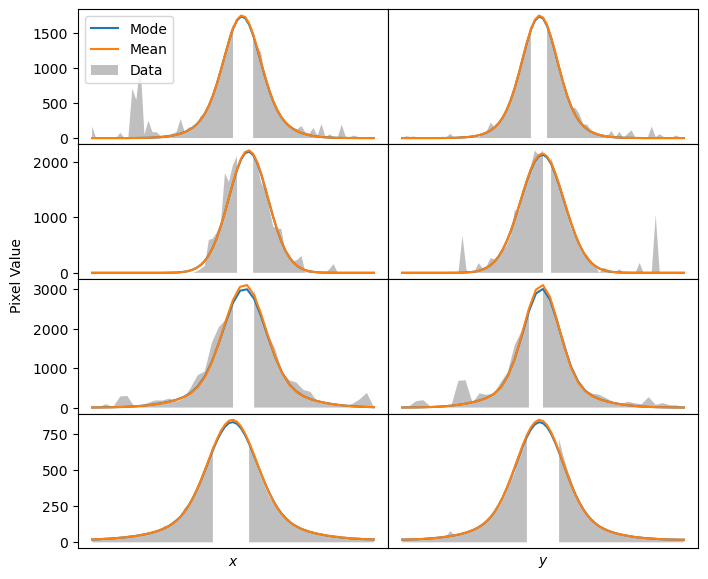

PyObject Text(0.04, 0.5, 'Pixel Value')

In [304]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_crossections(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

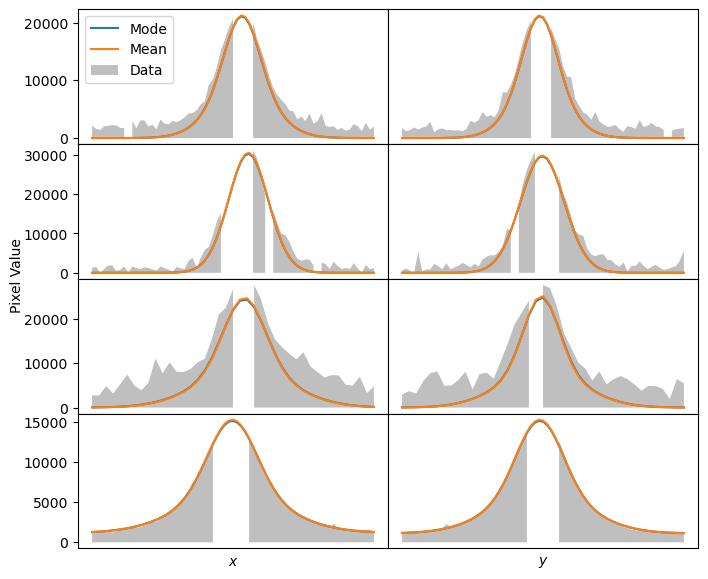

PyObject Text(0.04, 0.5, 'Pixel Value')

In [305]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_integral(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

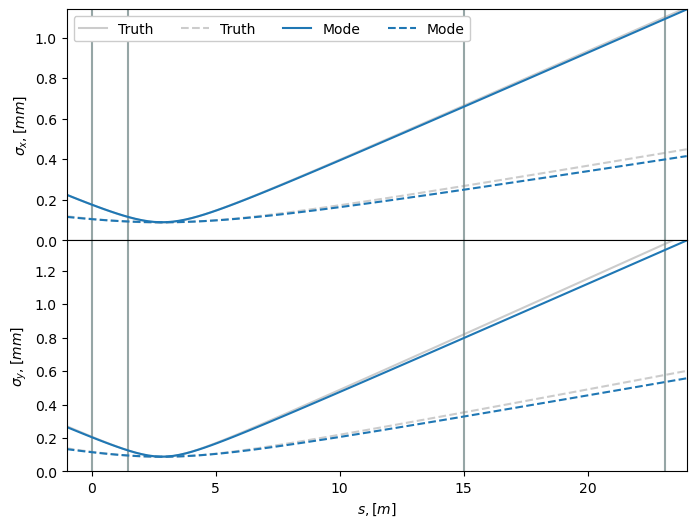

PyObject Text(0.5, 26.28125, '$s, [m]$')

In [306]:
params_array = [mode(samples)[1], mean(samples)[1]]
colors_array = ["gray", "C0", "C1"]
labels_array = ["Truth", "Mode", "Mean"]

plot_envelop_trajectory(params_array,  labels = labels_array, colors=colors_array)

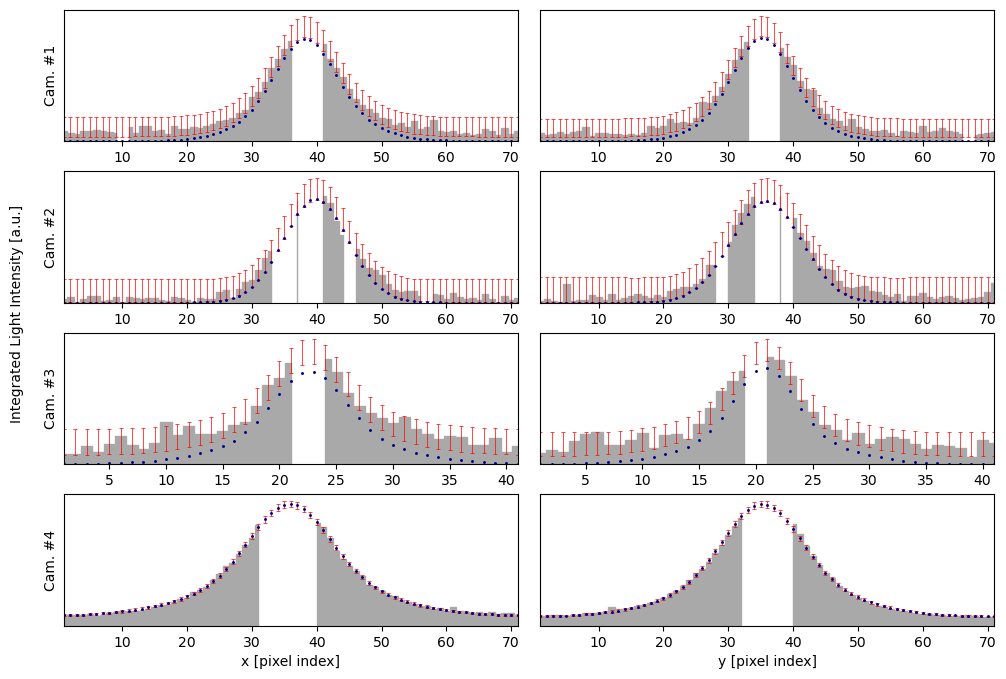

PyObject Text(0.08, 0.5, 'Integrated Light Intensity [a.u.]')

In [341]:
plot_projections(conv_matrices, event, event, params_array[1])